In [1]:
import pickle
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from strategy import Strategy

# Install a pip package in the current Jupyter kernel
import sys
!{sys.executable} -m pip install numpy_ringbuffer

In [2]:
pairs = ['btc_usd', 'eth_usd', 'ltc_usd', 'xrp_usd']

def pair_currencies(pairs):
    currencies = ['usd']
    for pair in pairs:
        currencies.append(pair.partition('_')[0])
    return currencies

/usr/local/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


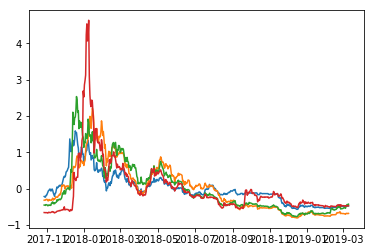

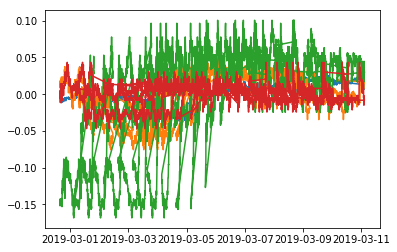

In [3]:
def prep_data(file):
    data = pickle.load(open(file, 'rb'))
    dates = [x['date'] for x in data]
    prices = [{k:v for k,v in x.items() if k in pairs} for x in data]
    return pd.DataFrame(prices, index = dates)

data = prep_data('data.p')
data_minute = prep_data('data-minute.p')
plt.plot(data / data.mean() - 1)
plt.show()
plt.plot(data_minute / data_minute.mean() - 1)
plt.show()

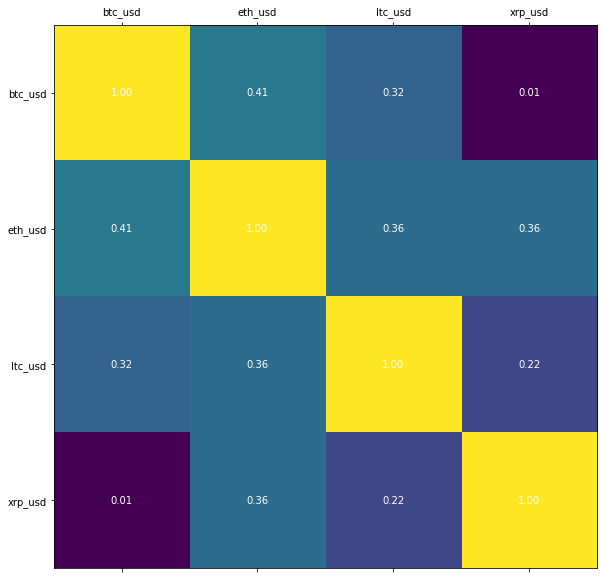

In [4]:
def plot_corr(df,size=10):
    '''Function plots a graphical correlation matrix for each pair of columns in the dataframe.

    Input:
        df: pandas DataFrame
        size: vertical and horizontal size of the plot'''

    corr = df.corr()
    fig, ax = plt.subplots(figsize=(size, size))
    ax.matshow(corr)
    plt.xticks(range(len(corr.columns)), corr.columns);
    plt.yticks(range(len(corr.columns)), corr.columns);
    # Loop over data dimensions and create text annotations.
    for i in range(len(corr.columns)):
        for j in range(len(corr.columns)):
            ax.text(j, i, '{:0.2f}'.format(corr.iloc[i, j]), ha="center", va="center", color="w")

plot_corr(data_minute)

In [5]:
def execute_orders(fees, prices, balances, orders):
    for (pair, size) in orders.items():
        # hacky...
        currency = pair.partition("_")[0]
        balances['usd'] -= size * prices[pair]
        balances[currency] += size

def pnl(balances, prices):
    usd = 0
    for (currency, qty) in balances.items():
        if currency == 'usd':
            usd += qty
        else:
            pair = currency + '_usd'
            usd += qty * prices[pair]
    return usd

def evaluate(strategy, data, fees = 0):
    '''data is prices per-day'''
    currencies = pair_currencies(data.columns)
    balances = dict.fromkeys(currencies, 0)
    results = []
    for (date, prices) in data.iterrows():
        orders = strategy.step(balances, prices)
        execute_orders(fees, prices, balances, orders)
        current_pnl = pnl(balances, prices)
        def price(currency):
            if currency == 'usd':
                return 1
            return prices[currency + '_usd']
        balance_values = { c: qty * price(c) for c, qty in balances.items()}
        results.append({ 'date': date, 'balances': balances.copy(), 'balance_values': balance_values, 'pnl': current_pnl, })
    return results

def plot_results(results):
    print('Final pnl:')
    print(results[-1]['pnl'])
    print('Final balances:')
    print(results[-1]['balances'])
    fig, axs = plt.subplots(1,2, figsize=(16, 4))
    balance_values = pd.DataFrame([x['balance_values'] for x in results], index = [x['date'] for x in results])
    pnls = pd.DataFrame([{ 'P/L': x['pnl']} for x in results], index = [x['date'] for x in results])
    pnls.plot(ax=axs[0])
    balance_values.plot(ax=axs[1])
    plt.show()

Final pnl:
0.0
Final balances:
{'usd': 0, 'btc': 0, 'eth': 0, 'ltc': 0, 'xrp': 0}


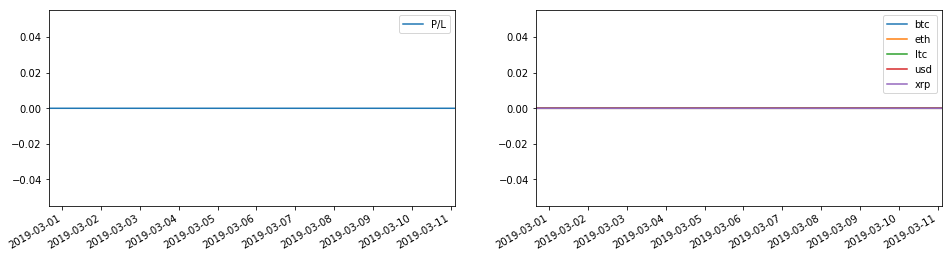

In [6]:
from strategy import HoldStrategy

plot_results(evaluate(HoldStrategy(), data_minute))

Final pnl:
10558.11379384541
Final balances:
{'usd': 10384.043128814405, 'btc': 0.0, 'eth': -3.2951592997317904, 'ltc': 21.68651929587584, 'xrp': -2006.551755590623}


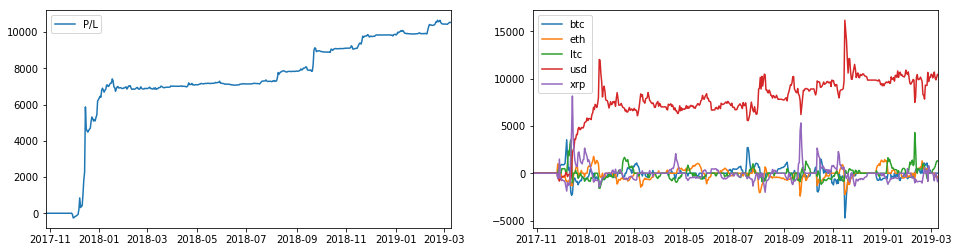

In [95]:
from strategy import MovingAverage
from numpy_ringbuffer import RingBuffer

class S(Strategy):
    def __init__(self, correlation_window_size, movement_half_life, size, min_edge = 0, max_edge = 1e100, correlation_subsampling = 1):
        '''edges are expressed in std deviations of the currency price
        size is $ per std dev. of edge
        '''
        self.moving_prices_history = None 
        self.correlation_window_size = correlation_window_size
        self.min_edge = min_edge
        self.max_edge = max_edge
        self.size = size
        self.moving_prices = MovingAverage(movement_half_life)
        self.correlation_subsampling = correlation_subsampling
        
    def desired_balance_value(self, edge):
        '''Returns (expressed in USD) the desired balance for a currency at the given edge from fair'''
        if abs(edge) < self.min_edge:
            return 0
        if abs(edge) >= self.max_edge:
            return 0
        return edge * self.size
        
    def step(self, balances, prices):
        if self.moving_prices_history is None:
            self.moving_prices_history = RingBuffer(self.correlation_window_size, dtype=(np.float, len(prices.index)))
        self.moving_prices.step(prices)
        self.moving_prices_history.append(self.moving_prices.value)
        
        if len(self.moving_prices_history) < self.correlation_window_size:
            return {}
        
        df = pd.DataFrame(np.array(self.moving_prices_history), columns = prices.index)
        
        # subsampling
        df = df.groupby(np.arange(len(df))//self.correlation_subsampling).mean()
        
        # Calaculates fair movements by averaging correlated movements between all pairs, weighted by r^2
        # Concretely:
        # fair_btc_movement =
        #   (btc_movment
        #    + eth_movement * r_eth^3 * stddev_btc/stddev_eth
        #    + ltc_movement * r_ltc^3 * stddev_btc/stddev_ltc
        #    + xrp_movement * r_xrp^3 * stddev_btc/stddev_xrp)
        #   / (1 + r_eth^2 + r_ltc^2 + r_xrp^2)
        
        # compute fairs, edges
        stddevs = df.std()
        corr = df.corr()
        deltas = prices - df.mean()
        predicted_deltas = (deltas * corr).mul(stddevs, axis=0).div(stddevs, axis=1)
        confidences = corr ** 2
        fair_deltas = (predicted_deltas * confidences).sum(axis=1) / confidences.sum(axis=1)
        edges = (deltas - fair_deltas) / stddevs
        
        # turn fairs into orders
        orders = {}
        for (pair, edge) in edges.items():
            currency = pair.partition('_')[0]
            orders[pair] = self.desired_balance_value(edges[pair]) / prices[pair] - balances[currency]
            
        return orders

plot_results(evaluate(S(correlation_window_size = 32, movement_half_life = 3, size = 1000, min_edge = 0.25), data))

In [ ]:
plot_results(evaluate(S(correlation_window_size = 32, movement_half_life = 3, size = 1000, min_edge = 0.25, correlation_subsampling = 1), data_minute))